## Task3：网站点击量预测

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# 忽略警告
warnings.filterwarnings("ignore")
# 正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 正常显示负号
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

### 数据读取


In [4]:
# data = pd.read_csv('dataset/Wikipedia.csv', index_col=0)
data = pd.read_csv('dataset/Wikipedia.csv')

# 查看前10行
print(data.head(10))

                                                Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   
5            5566_zh.wikipedia.org_all-access_spider        12.0         7.0   
6          91Days_zh.wikipedia.org_all-access_spider         NaN         NaN   
7           A'N'D_zh.wikipedia.org_all-access_spider       118.0        26.0   
8           AKB48_zh.wikipedia.org_all-access_spider         5.0        23.0   
9           ASCII_zh.wikipedia.org_all-access_spider         6.0         3.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0     

### 填补缺失值，去除异常值

In [5]:
data = data.interpolate(method='linear').dropna()

### 统计各语言、各访问类型的点击量

In [ ]:
data.sum()

### 进行分解分析

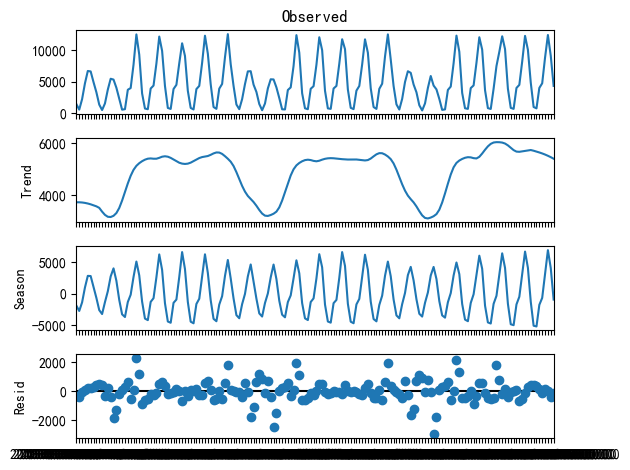

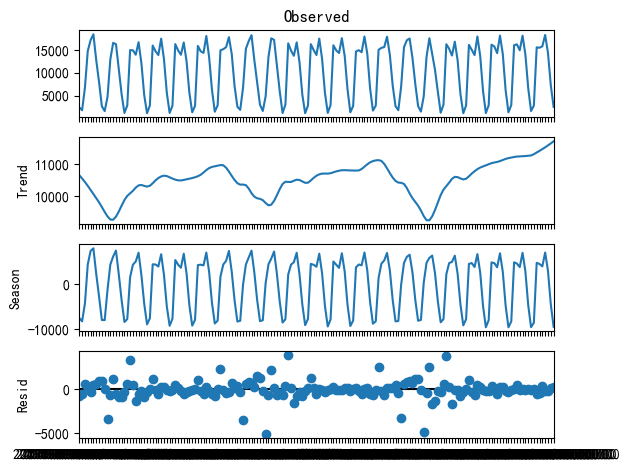

In [ ]:
decompositions7 = tsa.STL(datas7, period=8).fit()
decompositions94 = tsa.STL(datas94, period=8).fit()
decompositions7.plot()
decompositions94.plot()
# 趋势效应
trends7 = decompositions7.trend
# 季节效应
seasonals7 = decompositions7.seasonal
# 残差项
residuals7 = decompositions7.resid

# 趋势效应
trends94 = decompositions94.trend
# 季节效应
seasonals94 = decompositions94.seasonal
# 残差项
residuals94 = decompositions94.resid

### 平稳性检验

In [ ]:
def test_stationarity(timeseries, alpha=1e-3):
    dftest = tsa.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        
    print(dfoutput)
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:
        print('X 是平稳的')
        return True
    else:
        print('X 是非平稳的')
        return False

In [ ]:
test_stationarity(datas7)
print('*'*50)
test_stationarity(datas94)

Test Statistic                  -3.368380
p-value                          0.012085
#Lags Used                      10.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64
X 是非平稳的
**************************************************
Test Statistic                  -2.363583
p-value                          0.152280
#Lags Used                       9.000000
Number of Observations Used    159.000000
Critical Value (1%)             -3.472161
Critical Value (5%)             -2.879895
Critical Value (10%)            -2.576557
dtype: float64
X 是非平稳的


False

因此，传感器7序列和传感器94的序列均非平稳

### 因datas7非平稳，所以需要进行差分操作

In [ ]:
# 对序列进行季节差分-8步
# datas7_seasonal = datas7.diff(8)
# datas94_seasonal = datas94.diff(8)
datas7_seasonal = datas7.diff(8).dropna()
datas94_seasonal = datas94.diff(8).dropna()

test_stationarity(datas7_seasonal)
print('*'*50)
test_stationarity(datas94_seasonal)

Test Statistic                  -4.666276
p-value                          0.000097
#Lags Used                      14.000000
Number of Observations Used    145.000000
Critical Value (1%)             -3.476273
Critical Value (5%)             -2.881688
Critical Value (10%)            -2.577513
dtype: float64
X 是平稳的
**************************************************
Test Statistic                -1.108411e+01
p-value                        4.239113e-20
#Lags Used                     1.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64
X 是平稳的


True

因此无需再进行常查分

### 检验残差是否为白噪声

In [ ]:
def test_white_noise(data):
    return sm.stats.acorr_ljungbox(data.dropna(), return_df=True) # 小于阈值则为非白噪声

In [ ]:
test_white_noise(datas7_seasonal)

,lb_stat,lb_pvalue
1,65.853102,4.858151e-16
2,76.112636,2.967229e-17
3,82.686673,8.140200e-18
4,85.989729,9.353404e-18
5,85.997633,4.650076e-17
6,86.248972,1.818972e-16
7,86.591303,6.189875e-16
8,88.092066,1.133758e-15
9,89.263846,2.287337e-15
10,89.659873,6.255579e-15


In [ ]:
test_white_noise(datas94_seasonal)

,lb_stat,lb_pvalue
1,7.441649,0.006373
2,19.794230,0.000050
3,20.420883,0.000139
4,20.648819,0.000372
5,21.700401,0.000597
6,22.253485,0.001089
7,23.901368,0.001186
8,24.502819,0.001886
9,24.698182,0.003324
10,24.723569,0.005895


可以发现残差项是白噪声

### 画出ACF和PACF图像

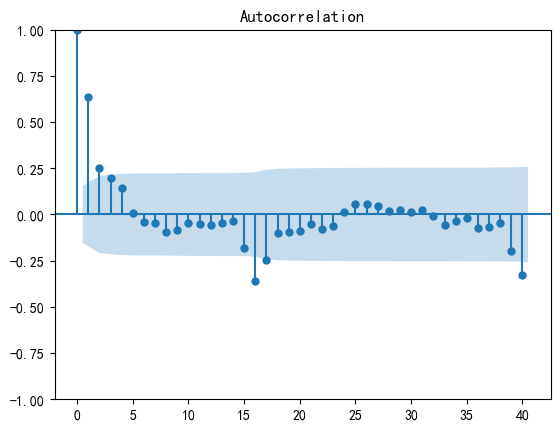

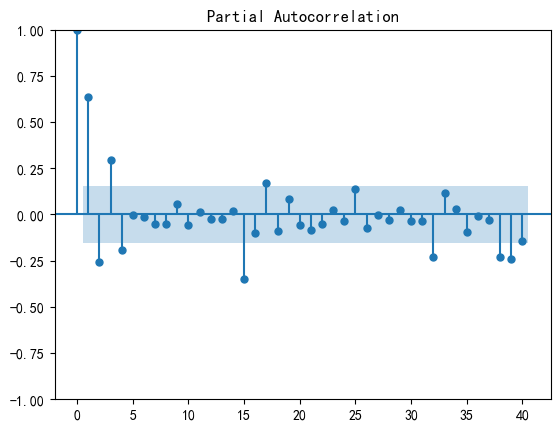

In [ ]:
fig = plot_acf(datas7_seasonal, lags=40)
fig = plot_pacf(datas7_seasonal, lags=40)

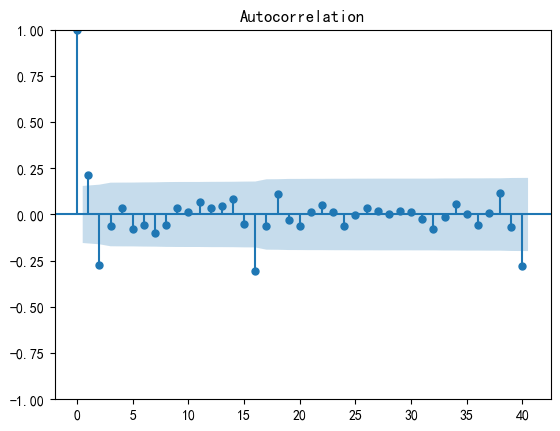

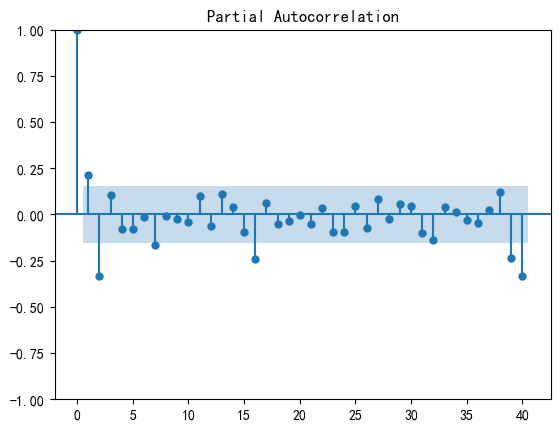

In [ ]:
fig = plot_acf(datas94_seasonal, lags=40)
fig = plot_pacf(datas94_seasonal, lags=40)

### 进行网格搜索

In [ ]:
def grid_search(data):
    p = q = range(0, 3)
    s = [8]
    d = [0,1]
    PDQs = list(itertools.product(p, d, q, s))
    pdq = list(itertools.product(p, d, q))
    params = []
    seasonal_params = []
    results = []
    grid = pd.DataFrame()
    
    for param in pdq:
        for seasonal_param in PDQs:
            mod = tsa.SARIMAX(data, order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False)
            result = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, seasonal_param, result.aic))
            params.append(param)
            seasonal_params.append(seasonal_param)
            results.append(result.aic)
            
    grid['pdq'] = params
    grid['PDQs'] = seasonal_params
    grid['aic'] = results
    print(grid[grid['aic'] == min(grid['aic'])])

In [ ]:
grid_search(datas7)

ARIMA(0, 0, 0)x(0, 0, 0, 8) - AIC:3385.684066111845
ARIMA(0, 0, 0)x(0, 0, 1, 8) - AIC:3128.2791819252366
ARIMA(0, 0, 0)x(0, 0, 2, 8) - AIC:2819.5236655844274
ARIMA(0, 0, 0)x(0, 1, 0, 8) - AIC:2820.6593242730387
ARIMA(0, 0, 0)x(0, 1, 1, 8) - AIC:2684.565055490206
ARIMA(0, 0, 0)x(0, 1, 2, 8) - AIC:2481.010814766142
ARIMA(0, 0, 0)x(1, 0, 0, 8) - AIC:2838.485058022502
ARIMA(0, 0, 0)x(1, 0, 1, 8) - AIC:2821.641130563723
ARIMA(0, 0, 0)x(1, 0, 2, 8) - AIC:2677.9762233150377
ARIMA(0, 0, 0)x(1, 1, 0, 8) - AIC:2702.0349924087063
ARIMA(0, 0, 0)x(1, 1, 1, 8) - AIC:2662.89657638493
ARIMA(0, 0, 0)x(1, 1, 2, 8) - AIC:2481.4407430742
ARIMA(0, 0, 0)x(2, 0, 0, 8) - AIC:2703.80479919503
ARIMA(0, 0, 0)x(2, 0, 1, 8) - AIC:2677.573226333787
ARIMA(0, 0, 0)x(2, 0, 2, 8) - AIC:2665.266861388228
ARIMA(0, 0, 0)x(2, 1, 0, 8) - AIC:2512.2916765084656
ARIMA(0, 0, 0)x(2, 1, 1, 8) - AIC:2493.479864251235
ARIMA(0, 0, 0)x(2, 1, 2, 8) - AIC:2487.8761505556686
ARIMA(0, 0, 1)x(0, 0, 0, 8) - AIC:3213.926321348177
ARIMA(0, 

In [ ]:
grid_search(datas94)

ARIMA(0, 0, 0)x(0, 0, 0, 8) - AIC:3637.0936209326765
ARIMA(0, 0, 0)x(0, 0, 1, 8) - AIC:3359.699446309672
ARIMA(0, 0, 0)x(0, 0, 2, 8) - AIC:3022.937129935211
ARIMA(0, 0, 0)x(0, 1, 0, 8) - AIC:2898.9099128015023
ARIMA(0, 0, 0)x(0, 1, 1, 8) - AIC:2756.894774892554
ARIMA(0, 0, 0)x(0, 1, 2, 8) - AIC:2566.375163192252
ARIMA(0, 0, 0)x(1, 0, 0, 8) - AIC:2917.4464072568253
ARIMA(0, 0, 0)x(1, 0, 1, 8) - AIC:2899.027374489355
ARIMA(0, 0, 0)x(1, 0, 2, 8) - AIC:2757.70827138482
ARIMA(0, 0, 0)x(1, 1, 0, 8) - AIC:2774.9884056945248
ARIMA(0, 0, 0)x(1, 1, 1, 8) - AIC:2739.9809029064063
ARIMA(0, 0, 0)x(1, 1, 2, 8) - AIC:2566.694115434965
ARIMA(0, 0, 0)x(2, 0, 0, 8) - AIC:2776.927759509747
ARIMA(0, 0, 0)x(2, 0, 1, 8) - AIC:2758.540617068912
ARIMA(0, 0, 0)x(2, 0, 2, 8) - AIC:2740.043140307284
ARIMA(0, 0, 0)x(2, 1, 0, 8) - AIC:2592.2453662391536
ARIMA(0, 0, 0)x(2, 1, 1, 8) - AIC:2585.6901956302345
ARIMA(0, 0, 0)x(2, 1, 2, 8) - AIC:2568.4118967128134
ARIMA(0, 0, 1)x(0, 0, 0, 8) - AIC:3478.025924261927
ARIMA

可以确定传感器7的参数为：pdq(0,1,2) PDQs(2,1,2,8)

传感器94的参数为：pdq(1,1,2) PDQs(2,1,2,8)

### 接下来进行参数检验

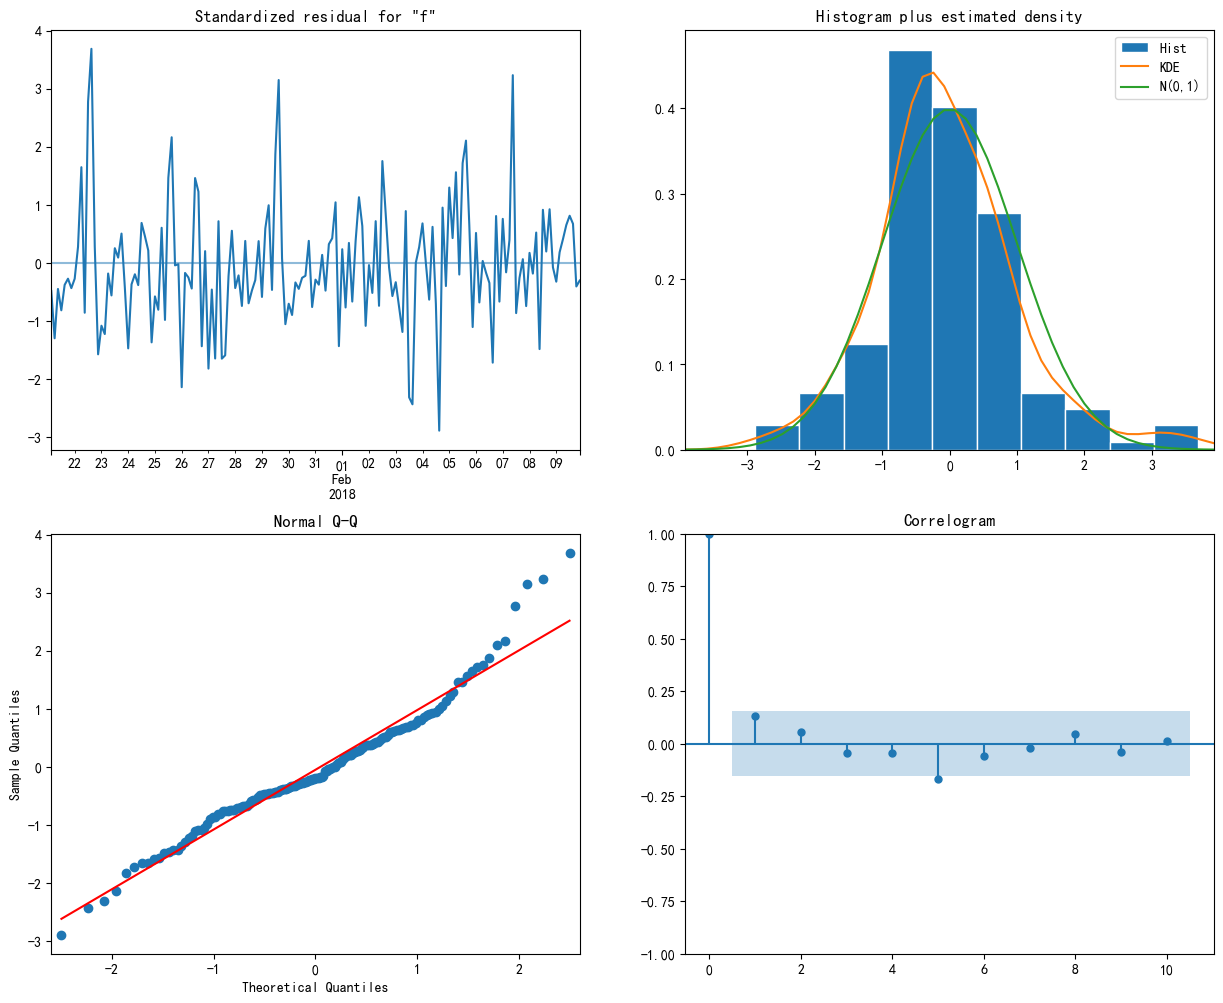

In [ ]:
mods7 = tsa.SARIMAX(datas7, order=(0,1,2), seasonal_order=(2,1,2,8))
resultss7 = mods7.fit()
test_white_noise(resultss7.resid)
fig_results7 = resultss7.plot_diagnostics(figsize=(15,12))

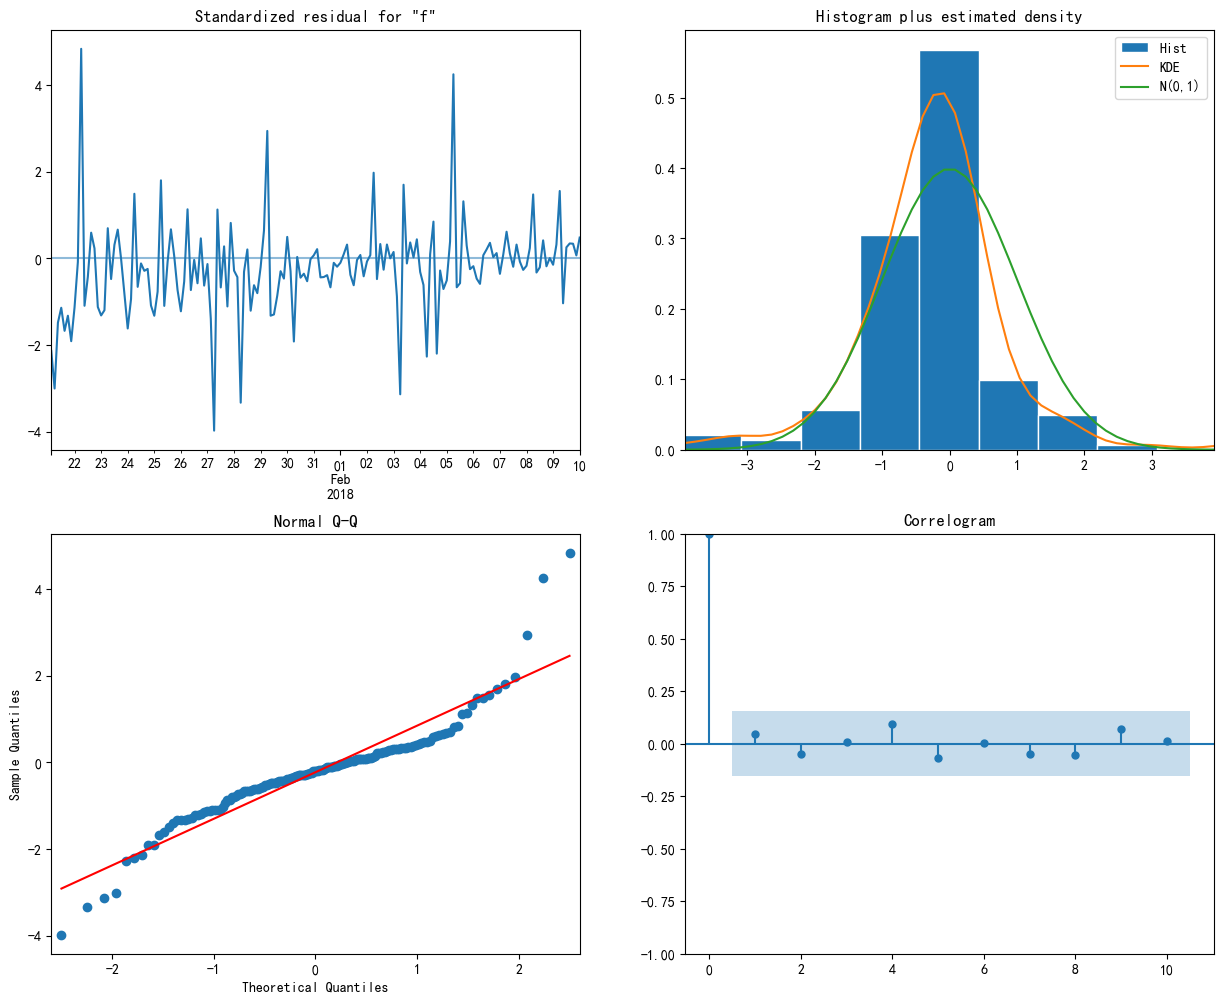

In [ ]:
mods94 = tsa.SARIMAX(datas94, order=(1,1,2), seasonal_order=(2,1,2,8))
resultss94 = mods94.fit()
test_white_noise(resultss94.resid)
fig_results94 = resultss94.plot_diagnostics(figsize=(15,12))

### 进行估计

In [ ]:
def get_prediction(data, results, start, dynamic=False):
    pred = results.get_prediction(start=start, dynamic=dynamic, full_results=True)
    pred_ci = pred.conf_int()
    forecast = pred.predicted_mean
    truth = data[start:]
    pred_concat = pd.concat([truth, forecast, pred_ci], axis=1)
    pred_concat.columns = ['true', 'pred', 'up', 'low']
    print('MSE: ', mean_squared_error(truth, forecast))
    print('RMSE: ', np.sqrt(mean_squared_error(truth, forecast)))
    return pred_concat

# 绘制预测结果
def plot_prediction(pred_concat):
    # 确保索引是 DatetimeIndex
    if not isinstance(pred_concat.index, pd.DatetimeIndex):
        pred_concat.index = pd.to_datetime(pred_concat.index)
    
    # 将时间戳转换为字符串
    pred_concat.index = pred_concat.index.strftime('%Y-%m-%d %H:%M:%S')
    
    plt.fill_between(pred_concat.index, pred_concat['up'], pred_concat['low'], alpha=0.4, label='pred_range')
    plt.plot(pred_concat['true'], label='true')
    plt.plot(pred_concat['pred'], label='pred')
    plt.legend()
    plt.show()
    

MSE:  622275.5607728402
RMSE:  788.8444464993337


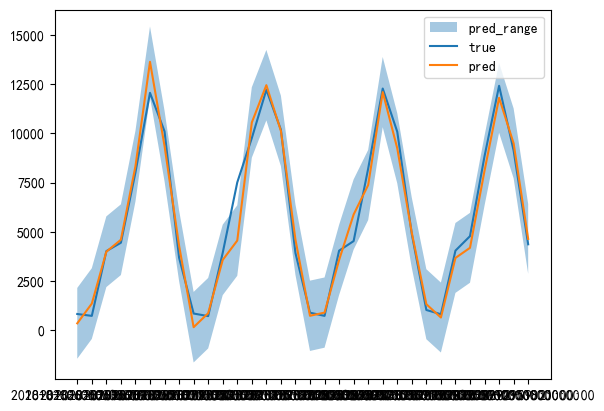

MSE:  1076545.0699350396
RMSE:  1037.566899016656


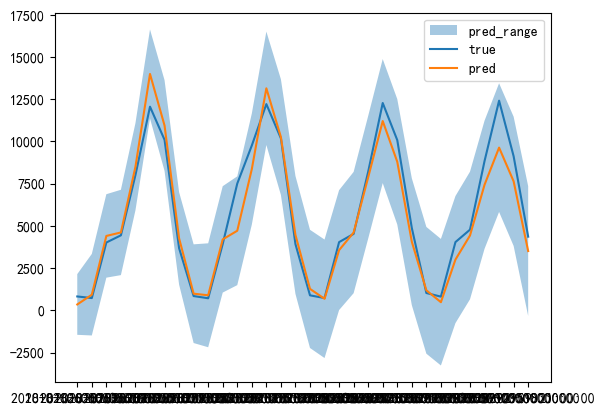

In [ ]:
# 静态预测-进行一系列的一步预测，即它必须用真实值来进行预测
preds7 = get_prediction(datas7, resultss7, '2018-02-06 00:00:00')
plot_prediction(preds7)

# 动态预测-除了第一个预测值是用实际值预测外，其后各预测值都是采用递推预测
preds7 = get_prediction(datas7, resultss7, '2018-02-06 00:00:00', dynamic=True)
plot_prediction(preds7)

MSE:  545238.4075050597
RMSE:  738.4026052940629


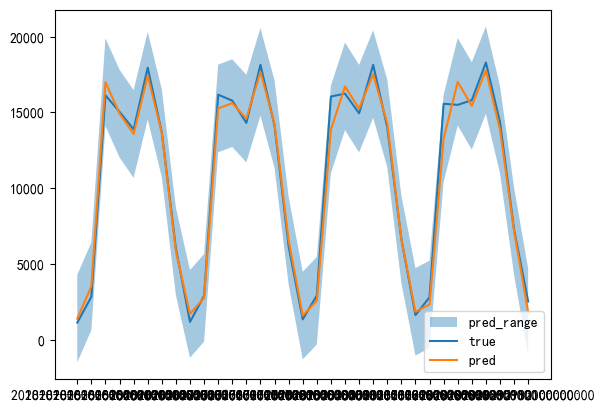

MSE:  980103.1740198437
RMSE:  990.0016030390273


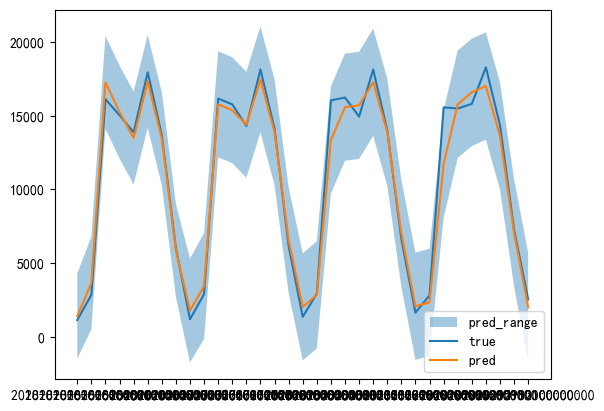

In [ ]:
# 静态预测-进行一系列的一步预测，即它必须用真实值来进行预测
preds94 = get_prediction(datas94, resultss94, '2018-02-06 00:00:00')
plot_prediction(preds94)

# 动态预测-除了第一个预测值是用实际值预测外，其后各预测值都是采用递推预测
preds94 = get_prediction(datas94, resultss94, '2018-02-06 00:00:00', dynamic=True)
plot_prediction(preds94)

### 进行未来预测

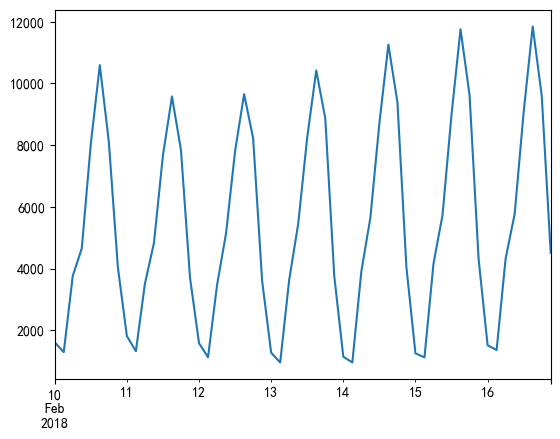

In [ ]:
forecasts7 = resultss7.get_forecast(steps=56)
fig = forecasts7.predicted_mean.plot()

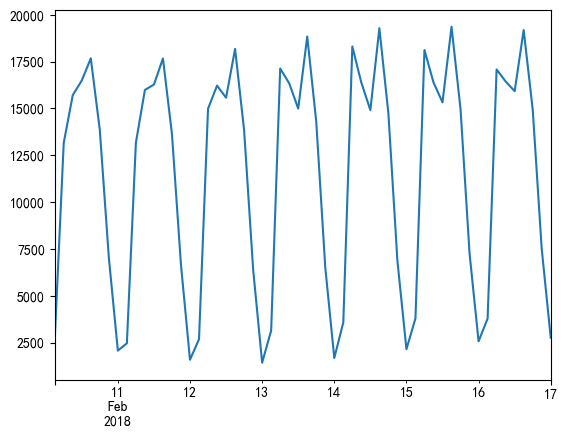

In [ ]:
forecasts94 = resultss94.get_forecast(steps=56)
fig = forecasts94.predicted_mean.plot()

### 展示最终预测结果

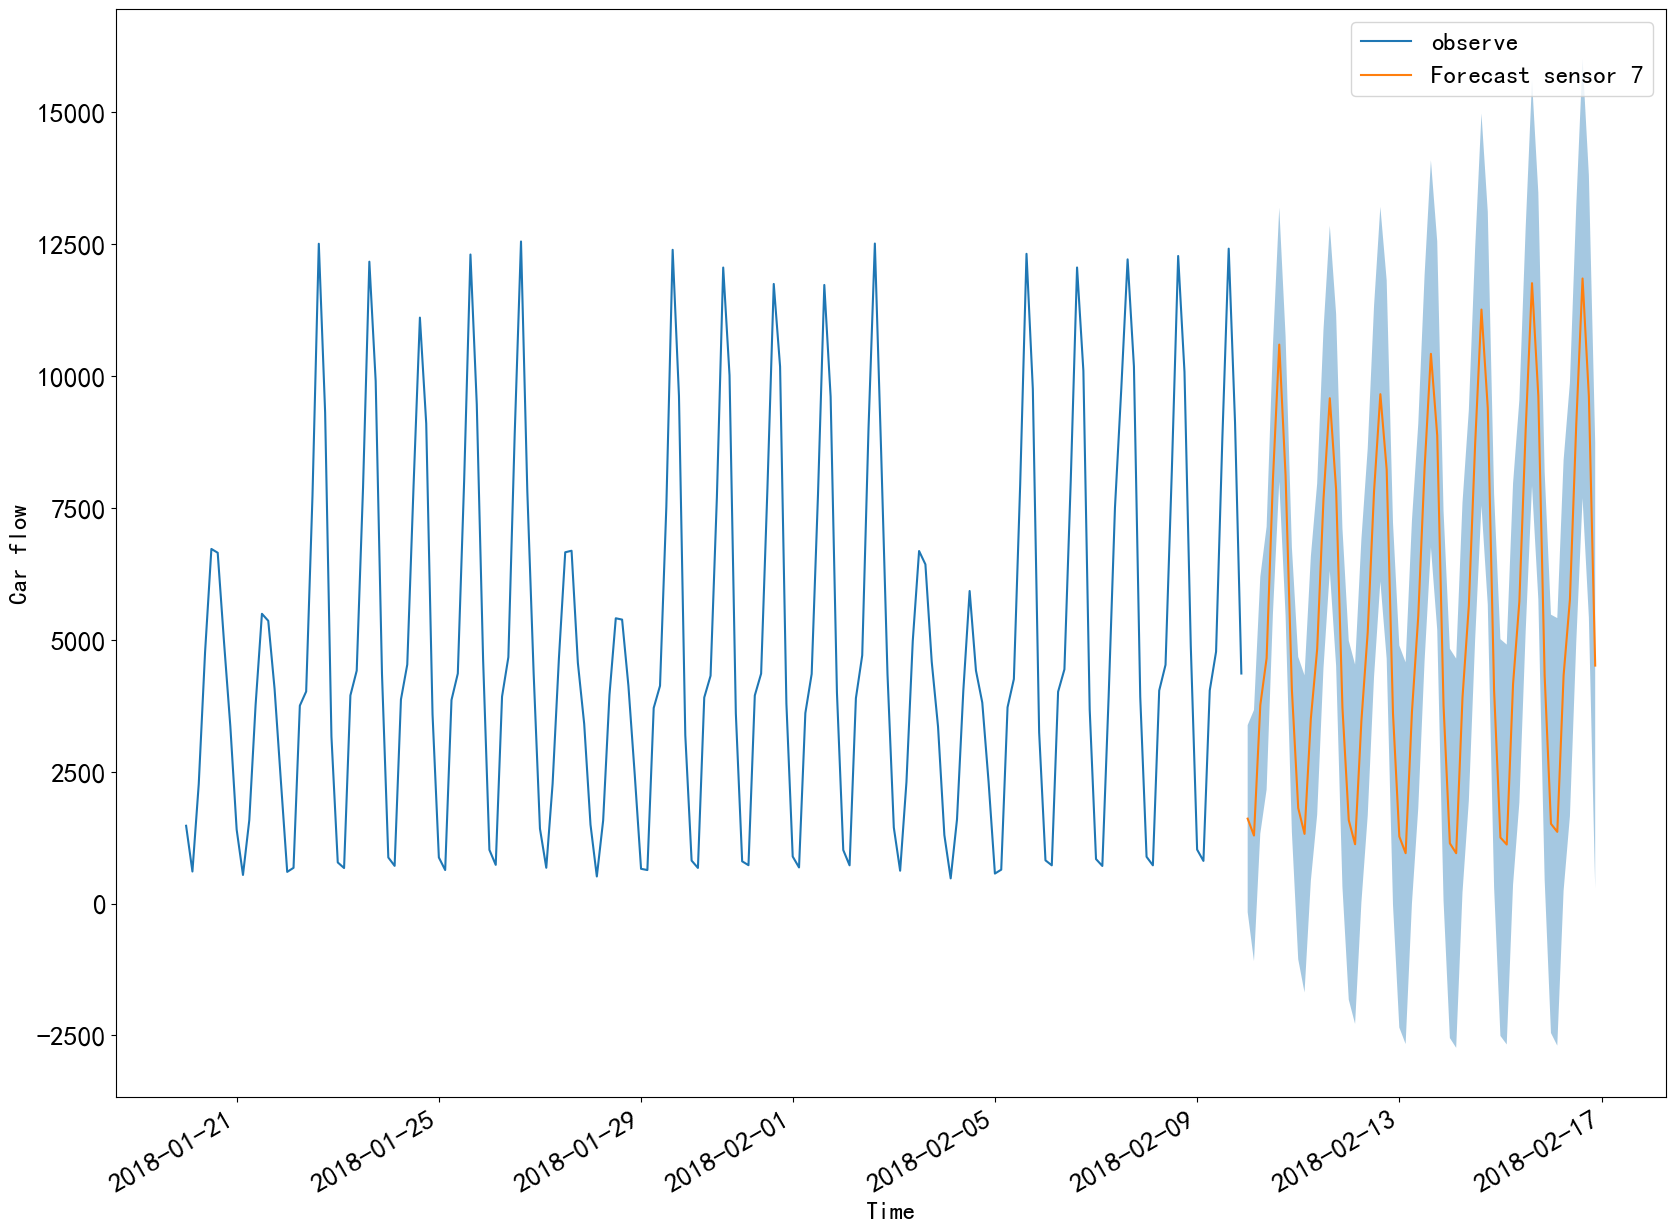

In [ ]:
# 确保 datas7 和 forecasts7 都有 DatetimeIndex
datas7.index = pd.to_datetime(datas7.index)
forecasts7.predicted_mean.index = pd.to_datetime(forecasts7.predicted_mean.index)

# 重新绘制图形
fig, ax = plt.subplots(figsize=(20,16))
ax.plot(datas7, label='observe')
forecasts7.predicted_mean.plot(ax=ax, label='Forecast sensor 7')
ax.fill_between(forecasts7.conf_int().index, 
                forecasts7.conf_int().iloc[:, 0], 
                forecasts7.conf_int().iloc[:, 1], alpha=0.4)
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Car flow', fontsize=18)
ax.legend(loc='best', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

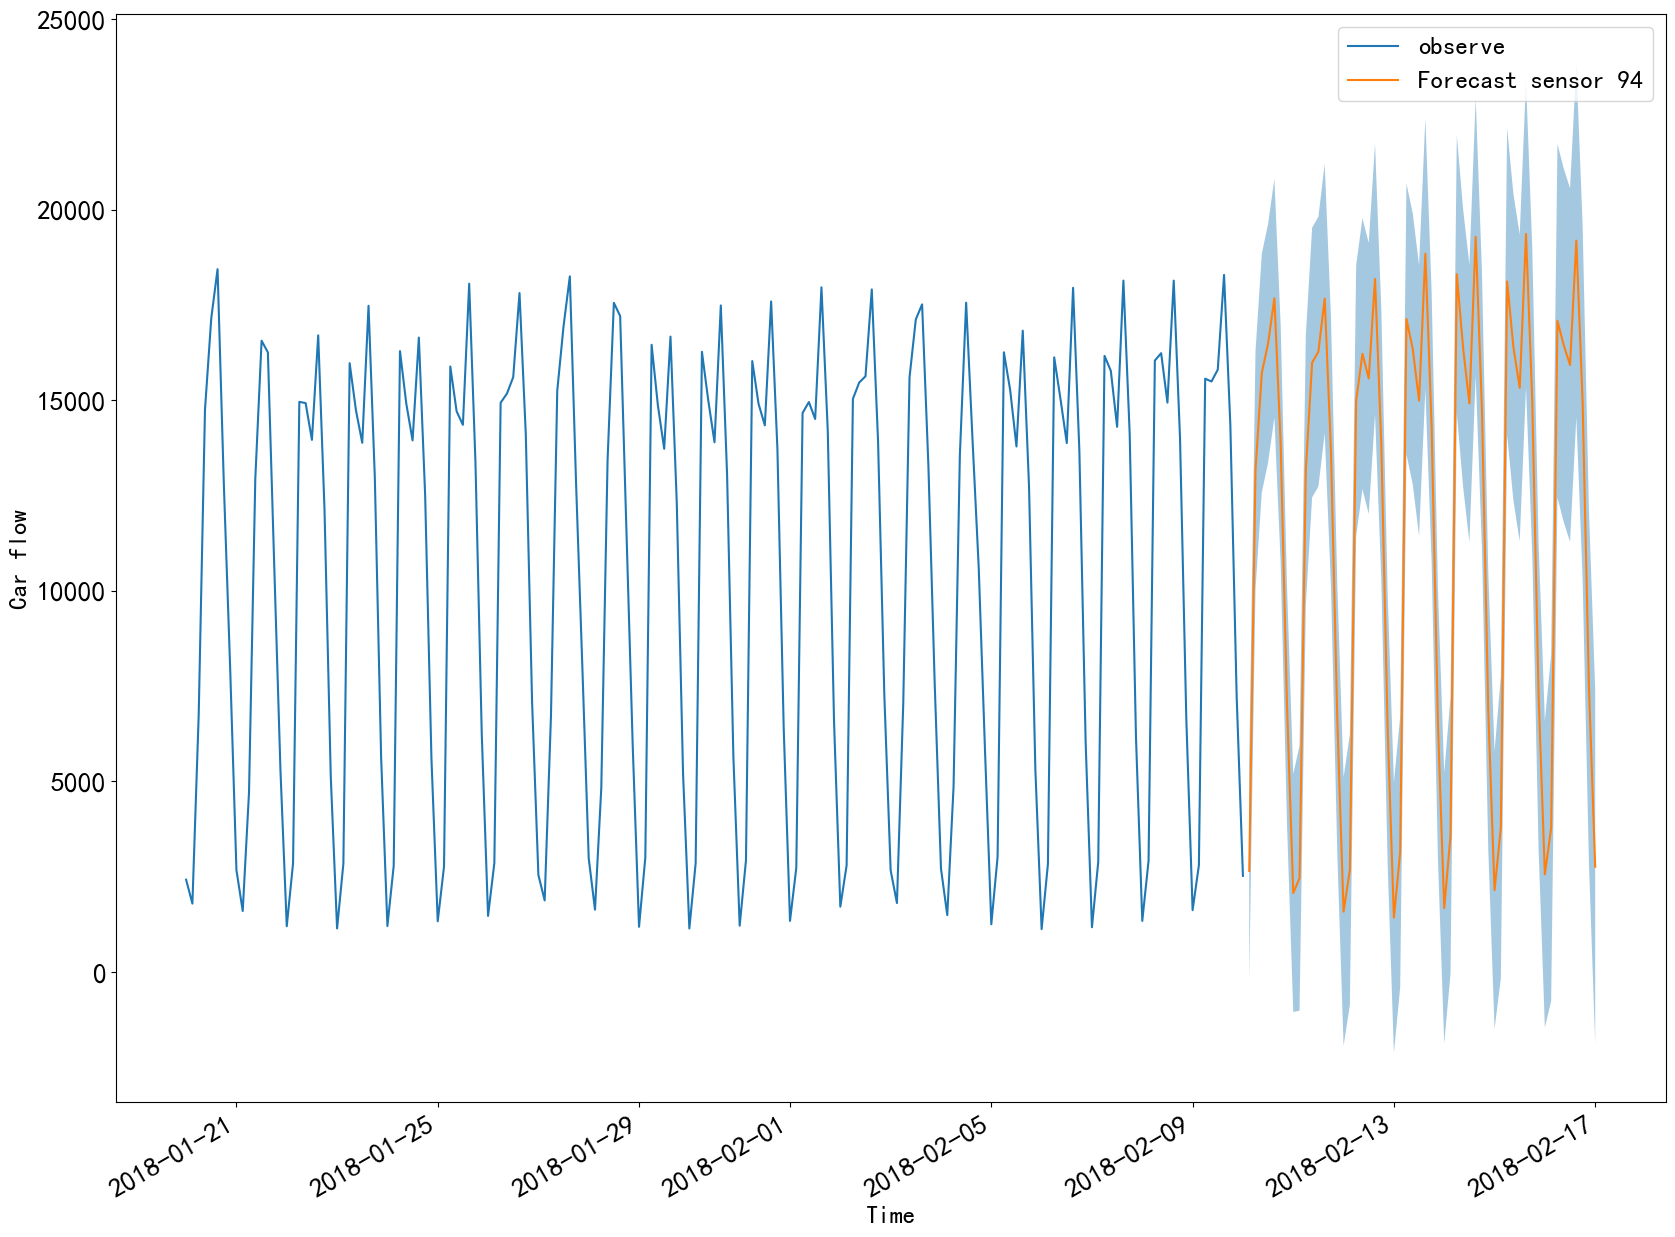

In [ ]:
datas94.index = pd.to_datetime(datas94.index)
forecasts94.predicted_mean.index = pd.to_datetime(forecasts94.predicted_mean.index)

# 重新绘制图形
fig, ax = plt.subplots(figsize=(20,16))
ax.plot(datas94, label='observe')
forecasts94.predicted_mean.plot(ax=ax, label='Forecast sensor 94')
ax.fill_between(forecasts94.conf_int().index, 
                forecasts94.conf_int().iloc[:, 0], 
                forecasts94.conf_int().iloc[:, 1], alpha=0.4)
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Car flow', fontsize=18)
ax.legend(loc='best', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
